In [ ]:
# DuTracer Fig 4K-L
# compare the transcriptional difference between CPM-related heart cells and non CPM-related heart cells

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggsci)
library(scales)
library(ggrepel)

Attaching SeuratObject

‘SeuratObject’ was built under R 4.2.0 but the current version is
4.2.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
dat = readRDS("../data/EBcombined.rds")
dat

An object of class Seurat 
29082 features across 32738 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [3]:
#color: similar cell type with similar colors, different cell type with different colors
cell_type = c('Heart','Neuron', 'Gut','Blood', 'CPM','PGC-like','Endothelium', 'FHF', 'SHF')
colors = c('#1F77B4FF','#FF7F0EFF','#2CA02CFF','#D62728FF','#9467BDFF','#8C564BFF','#E377C2FF', '#BCBD22FF', '#17BECFFF')
cl_cols = setNames(colors, cell_type)

# options(repr.plot.width=8, repr.plot.height=8)
# DimPlot(dat, reduction = 'umap', group.by = 'cell_type', cols = cl_cols, label = TRUE, repel=TRUE, , pt.size = 0.5, label.size=6) + NoLegend()


In [6]:
# markers = c('Hand1', 'Tbx5', 'Nkx2-5', 'Hcn4', 'Sfrp5', # First heart field
#     'Isl1', 'Foxc2', 'Tbx1', 'Fgf8', 'Hoxa1', 'Hoxb1') # second heart field

# DefaultAssay(dat) = 'RNA'
# options(repr.plot.width=15, repr.plot.height=9)
# FeaturePlot(dat, features=markers, ncol=5, order=TRUE)
# options(repr.plot.width=6, repr.plot.height=3)
# FeaturePlot(dat, features=c('H19', 'Prrx1'), ncol=2, order=TRUE)

In [4]:
# only these four samples contains SHF cells
D8b = read.csv('../data/EBzhumiao_allele_table/EB_D8b_allele_table_greedy.csv', row.names=1)
D10b = read.csv('../data/EBzhumiao_allele_table/EB_D10b_allele_table_greedy.csv', row.names=1)
D12 = read.csv('../data/EBzhumiao_allele_table/EB_D12_allele_table_greedy.csv', row.names=1)
D14 = read.csv('../data/EBzhumiao_allele_table/EB_D14e_allele_table_greedy.csv', row.names=1)

In [5]:
#preprocess
D8b$cellBC = paste0(D8b$cellBC, '_3')
D10b$cellBC = paste0(D10b$cellBC, '_4')
D12$cellBC = paste0(D12$cellBC, '_5')
D14$cellBC = paste0(D14$cellBC, '_6')

D8b$orig.ident = 'EBd8'
D10b$orig.ident = 'EBd10'
D12$orig.ident = 'EBd12'
D14$orig.ident = 'EBd14'

D8b = D8b %>% dplyr::select(orig.ident, lineageGrp, cellBC)
D10b = D10b %>% dplyr::select(orig.ident, lineageGrp, cellBC)
D12 = D12 %>% dplyr::select(orig.ident, lineageGrp, cellBC)
D14 = D14 %>% dplyr::select(orig.ident, lineageGrp, cellBC)

amplicon = rbind(D8b, D10b, D12, D14)

In [6]:
metadata = dat@meta.data %>% mutate(cellBC = rownames(.)) %>% dplyr::select(cellBC, cell_type)
head(metadata)

,cellBC,cell_type
,<chr>,<chr>
CELL454_N3_1,CELL454_N3_1,Heart
CELL1270_N1_1,CELL1270_N1_1,Heart
CELL1244_N1_1,CELL1244_N1_1,Gut
CELL37_N2_1,CELL37_N2_1,Heart
CELL608_N1_1,CELL608_N1_1,Heart
CELL101_N3_1,CELL101_N3_1,Heart


In [7]:
amp_transcript = unique(inner_join(amplicon, metadata, by='cellBC'))
# amp_transcript = inner_join(amplicon, metadata, by='cellBC')
head(amp_transcript)

,orig.ident,lineageGrp,cellBC,cell_type
,<chr>,<int>,<chr>,<chr>
1,EBd8,1,CELL1001_N2_3,Heart
4,EBd8,2,CELL1002_N2_3,Heart
8,EBd8,27,CELL1003_N2_3,Heart
9,EBd8,24,CELL1017_N2_3,Heart
10,EBd8,3,CELL1019_N2_3,Heart
17,EBd8,16,CELL1020_N2_3,Heart


In [27]:
# select those lineageGrp with CPM celltypes
# cpm_linGrp = amp_transcript %>% filter(cell_type == 'CPM') %>% group_by(orig.ident) %>% reframe(lineageGrp = unique(lineageGrp))
# cpm_linGrp = amp_transcript %>%
#   group_by(orig.ident, lineageGrp) %>%
#   reframe(CPM_percentage = sum(cell_type == "CPM") / n()) %>%
#   filter(CPM_percentage > 0.2)
# head(cpm_linGrp)

In [8]:
cpm_linGrp = amp_transcript %>%
  group_by(orig.ident, lineageGrp) %>%
  reframe(CPM_percentage = sum(cell_type == "CPM") / n()) %>%
  filter(CPM_percentage > 0.182) # cutoff with enough cell to perform differential expression

In [9]:
selected_amp_transcript = inner_join(cpm_linGrp[,c('orig.ident', 'lineageGrp')], amp_transcript, by = c('orig.ident', 'lineageGrp'))
selected_amp_transcript = unique(selected_amp_transcript)
head(selected_amp_transcript)

orig.ident,lineageGrp,cellBC,cell_type
<chr>,<int>,<chr>,<chr>
EBd12,0,CELL1063_N2_5,Gut
EBd12,0,CELL1131_N4_5,Heart
EBd12,0,CELL1364_N2_5,Heart
EBd12,0,CELL1856_N2_5,Heart
EBd12,0,CELL2061_N2_5,Heart
EBd12,0,CELL222_N2_5,Heart


In [10]:
# select potential SHF cells
possible_SHF = selected_amp_transcript %>% filter(cell_type == 'Heart') %>% select(cellBC) %>% unlist() %>% unique()
tail(possible_SHF)

[1] "CELL3046_N1_3" "CELL449_N2_3"  "CELL852_N2_3"  "CELL1510_N1_3"
[5] "CELL2234_N1_3" "CELL725_N2_3"

In [11]:
all_heart_cells = amp_transcript %>% filter(cell_type == 'Heart') %>% select(cellBC) %>% unlist() %>% unique()
length(all_heart_cells)

[1] 3814

In [12]:
possible_FHF = setdiff(all_heart_cells, possible_SHF)

In [13]:
dat@meta.data$cellBC = rownames(dat@meta.data)
dat@meta.data$shf = ifelse(dat@meta.data$cellBC %in% possible_SHF, 
                           'SHF', ifelse(dat@meta.data$cellBC %in% possible_FHF, 'FHF',dat@meta.data$cell_type))


In [14]:
dat@meta.data$cellBC = rownames(dat@meta.data)
dat@meta.data$shf1 = ifelse(dat@meta.data$cellBC %in% possible_SHF, 
                           'SHF', ifelse(dat@meta.data$cellBC %in% possible_FHF, 'FHF','Others'))

In [15]:
colors = setNames(c('darkgray','red','lightgray'), c('FHF', 'SHF', 'Others'))

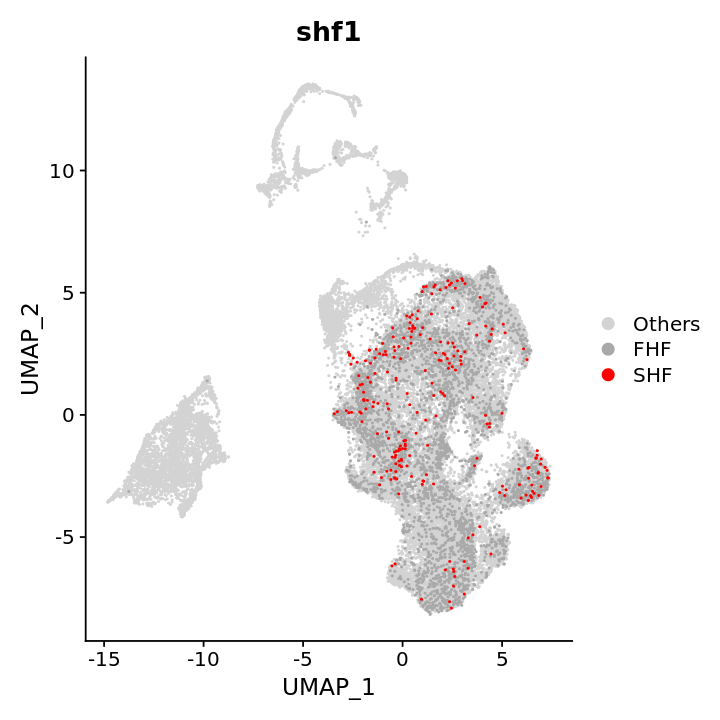

In [16]:
options(repr.plot.width=6, repr.plot.height=6)
DimPlot(dat, reduction = 'umap', group.by = 'shf1', cols=colors, pt.size = 0.2, label.size=6, 
        order = c('SHF', 'FHF','Others'))
ggsave('../results/Fig4_mouseEB_clone_based_FHF_SHF_distribution.pdf', width=6, height=6)

In [62]:
# Idents(dat) = dat$shf1
# shf_markers = FindMarkers(dat, ident.1 = 'SHF', ident.2 = 'FHF', assay='RNA')
# shf_markers$gene = rownames(shf_markers)

In [17]:
# rerun the process using Rscript mouseEB_heart.r in conda r4_base enviroment, major difference in Seurat versions
# write.csv(shf_markers, '/data1/home/gdpeng/chengchen/dualproject/datasets/EB_all_SHF_vs_FHF_genes.csv')
shf_markers = read.csv('../data/EB_all_SHF_vs_FHF_genes.csv', row.names=1)
head(shf_markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Igf2,6.158692e-43,-1.3674998,0.762,0.954,1.667897e-38,Igf2
Mest,8.160066e-23,-0.9590159,0.301,0.671,2.209909e-18,Mest
mt-Nd3,1.201984e-21,-0.4190045,1.000,1.000,3.255213e-17,mt-Nd3
Gata6,3.907291e-21,-0.7035846,0.665,0.880,1.058172e-16,Gata6
H19,1.250224e-20,0.8452272,0.841,0.596,3.385856e-16,H19
mcherry,6.469554e-19,0.4918695,1.000,0.999,1.752085e-14,mcherry


In [19]:
# Figure S6E differentially expressed genes between FHF and SHF
# options(repr.plot.width=6, repr.plot.height=6)
# ggplot() + 
#     geom_point(data = shf_markers, aes(x = avg_log2FC, y=-log10(p_val_adj)), color='gray')+
#     geom_point(data = shf_markers %>% filter(avg_log2FC>0.4 & -log10(p_val_adj)>2), aes(x = avg_log2FC, y=-log10(p_val_adj)), color='#E64B35FF') +
#     geom_point(data = shf_markers %>% filter(avg_log2FC<(-0.4) & -log10(p_val_adj)>2), aes(x = avg_log2FC, y=-log10(p_val_adj)), color='#00A087FF')+
#     geom_vline(xintercept=c(-0.4,0.4),lty='longdash',col="black",lwd=0.6)+
#     geom_hline(yintercept=2,lty='longdash',col="black",lwd=0.6)+
#     scale_x_continuous(limits=c(-2, 2))+
#     geom_text_repel(data = shf_markers %>% filter(avg_log2FC<(-0.7) & -log10(p_val_adj)>2), aes(x = avg_log2FC, y=-log10(p_val_adj), label=gene))+
#     geom_text_repel(data = shf_markers %>% filter(avg_log2FC>0.7 & -log10(p_val_adj)>2), aes(x = avg_log2FC, y=-log10(p_val_adj), label=gene))+
#     theme_classic(base_size=14)
# ggsave('/data1/home/gdpeng/chengchen/dualproject/figures/CSC/mouseEB_clone_based_FHF_SHF_DEGs.pdf', width=6, height=6)

Warning message:
“The following features are not present in the object: Atrnl1, Tshz3, not searching for symbol synonyms”


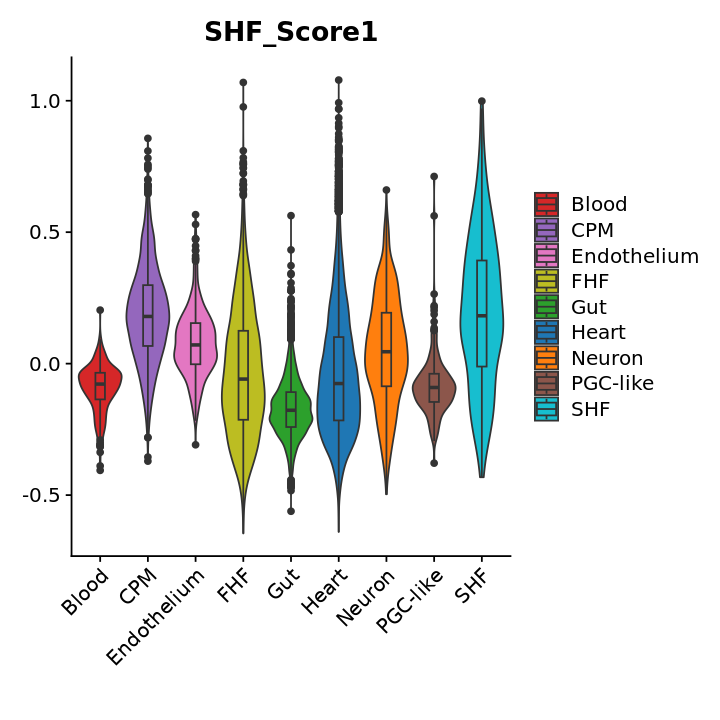

In [18]:
genes = shf_markers %>% filter(avg_log2FC>0.4 & p_val_adj < 0.05 & (pct.1-pct.2)>0.1)
dat <- AddModuleScore(object = dat, features = list(rownames(genes)), ctrl = 50, name = 'SHF_Score')
options(repr.plot.width=6, repr.plot.height=6)
VlnPlot(dat, features = "SHF_Score1", group.by="shf",pt.size=0, cols=cl_cols)+geom_boxplot(width=0.2)+xlab("")
ggsave('../results/Fig4_mouseEB_clone_based_SHF_signatures.pdf', width=6, height=6)